In [1]:
from pathlib import Path
import pandas as pd


import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

import cv2


import warnings
warnings.filterwarnings('ignore')

In [2]:
path = Path('csv_out')

eval_video_path = Path('eval_model_on_video')

In [3]:
!ls {eval_video_path}

output_with_predictions.mp4  show_model_behav.py
scaler.save		     trajectory_predictor.pth


In [6]:

# 读取数据
df1 = pd.read_csv(path / 'tracking_data.csv')
df2 = pd.read_csv(path / 'overall_turn_label.csv')

# 合并数据帧
df_merged = pd.merge(df1, df2[['id', 'frame', 'overall_turn_label']], on=['id', 'frame'], how='left')

# 按 id 分组，对 overall_turn_label 进行前向和后向填充V
df_merged['overall_turn_label'] = df_merged.groupby('id')['overall_turn_label'].fillna(method='ffill')
df_merged['overall_turn_label'] = df_merged.groupby('id')['overall_turn_label'].fillna(method='bfill')

# 检查是否仍有缺失值
missing_values = df_merged['overall_turn_label'].isnull().sum()
print(f"缺失的 overall_turn_label 数量：{missing_values}")

# 如果仍有缺失值，可以选择填充默认值或删除这些行
df_merged['overall_turn_label'] = df_merged['overall_turn_label'].fillna('straight')

# 对 overall_turn_label 进行 One-Hot 编码
encoder = OneHotEncoder(sparse_output=False)
turn_labels_encoded = encoder.fit_transform(df_merged[['overall_turn_label']])
turn_label_columns = encoder.get_feature_names_out(['overall_turn_label'])
df_merged[turn_label_columns] = turn_labels_encoded

# 定义输入特征
input_features = ['center_x', 'center_y'] + list(turn_label_columns)

# 定义序列长度
sequence_length = 90
predict_length = 30

# 生成输入和目标序列
input_sequences = []
target_sequences = []
sequence_vehicle_ids = []

grouped = df_merged.groupby('id')

for track_id, group in grouped:
    group = group.sort_values('frame').reset_index(drop=True)
    features = group[input_features].values

    num_sequences = len(features) - sequence_length - predict_length + 1
    if num_sequences <= 0:
        continue

    for i in range(num_sequences):
        input_seq = features[i:i + sequence_length]
        target_seq = features[i + sequence_length:i + sequence_length + predict_length, :2]  # 只取 center_x 和 center_y

        input_sequences.append(input_seq)
        target_sequences.append(target_seq)
        sequence_vehicle_ids.append(track_id)

# 转换为 NumPy 数组
input_sequences = np.array(input_sequences)
target_sequences = np.array(target_sequences)
sequence_vehicle_ids = np.array(sequence_vehicle_ids)

# 数据标准化
numeric_feature_indices = [0, 1]  # 'center_x', 'center_y'

all_numeric_inputs = input_sequences[:, :, numeric_feature_indices].reshape(-1, len(numeric_feature_indices))

scaler = StandardScaler()
scaler.fit(all_numeric_inputs)

input_sequences[:, :, numeric_feature_indices] = scaler.transform(all_numeric_inputs).reshape(input_sequences.shape[0], input_sequences.shape[1], len(numeric_feature_indices))

all_numeric_targets = target_sequences.reshape(-1, len(numeric_feature_indices))
target_sequences = scaler.transform(all_numeric_targets).reshape(target_sequences.shape[0], target_sequences.shape[1], len(numeric_feature_indices))

# 接下来，你可以按照之前的方式进行模型训练

/tmp/ipykernel_1001825/1429454791.py:9: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  df_merged['overall_turn_label'] = df_merged.groupby('id')['overall_turn_label'].fillna(method='ffill')
/tmp/ipykernel_1001825/1429454791.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_merged['overall_turn_label'] = df_merged.groupby('id')['overall_turn_label'].fillna(method='ffill')
/tmp/ipykernel_1001825/1429454791.py:10: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  df_merged['overall_turn_label'] = df_merged.groupby('id')['overall_turn_la

缺失的 overall_turn_label 数量：0


In [27]:
# 你感兴趣的车辆 ID 列表
vehicle_ids_of_interest = [50, 328, 220, 46, 201, 238, 278, 185, 309, 303, 74, 93, 127, 203, 219, 210, 280, 390]

# 创建一个字典，键为 vehicle_id，值为对应的索引列表
vehicle_id_to_indices = {}

for vehicle_id in vehicle_ids_of_interest:
    indices = np.where(sequence_vehicle_ids == vehicle_id)[0]
    if len(indices) > 0:
        vehicle_id_to_indices[vehicle_id] = indices
    else:
        print(f"Vehicle ID {vehicle_id} not found in the sequences.")

In [28]:
vehicle_id_to_indices

{50: array([132139, 132140, 132141, ..., 133240, 133241, 133242]),
 328: array([232834, 232835, 232836, ..., 234290, 234291, 234292]),
 220: array([188621, 188622, 188623, ..., 190853, 190854, 190855]),
 46: array([131953, 131954, 131955, 131956, 131957, 131958, 131959, 131960,
        131961, 131962, 131963, 131964, 131965, 131966, 131967, 131968,
        131969, 131970, 131971, 131972, 131973, 131974, 131975, 131976,
        131977, 131978, 131979, 131980, 131981, 131982, 131983, 131984,
        131985, 131986, 131987, 131988, 131989, 131990, 131991, 131992,
        131993, 131994, 131995, 131996, 131997, 131998, 131999, 132000,
        132001, 132002, 132003, 132004, 132005, 132006, 132007, 132008,
        132009, 132010, 132011, 132012, 132013, 132014, 132015, 132016,
        132017, 132018, 132019, 132020, 132021, 132022, 132023, 132024,
        132025, 132026, 132027, 132028, 132029, 132030, 132031, 132032,
        132033, 132034, 132035, 132036, 132037, 132038, 132039, 132040,
 

In [13]:
df_merged.head()

,frame,time,id,class,center_x,center_y,speed_kmh,overall_turn_label,overall_turn_label_left_turn,overall_turn_label_right_turn,overall_turn_label_straight
0,1,0.034483,1,car,385,281,NaN,right_turn,0.0,1.0,0.0
1,1,0.034483,2,car,358,124,NaN,straight,0.0,0.0,1.0
2,1,0.034483,3,car,245,263,NaN,straight,0.0,0.0,1.0
3,1,0.034483,4,car,382,322,NaN,straight,0.0,0.0,1.0
4,1,0.034483,5,car,439,272,NaN,straight,0.0,0.0,1.0


In [ ]:
df.columns

In [8]:

# # 填充缺失值
# df['speed_kmh'] = df['speed_kmh'].fillna(method='ffill')
# df['speed_kmh'] = df['speed_kmh'].fillna(0)

# # 计算速度变化和加速度
# df['speed_diff'] = df.groupby('id')['speed_kmh'].diff().fillna(0)
# df['time_diff'] = df.groupby('id')['time'].diff().fillna(0)
# df['acceleration'] = df['speed_diff'] / df['time_diff']
# df['acceleration'] = df['acceleration'].fillna(0)

# # 计算运动方向
# df['delta_x'] = df.groupby('id')['center_x'].diff().fillna(0)
# df['delta_y'] = df.groupby('id')['center_y'].diff().fillna(0)
# df['direction'] = np.arctan2(df['delta_y'], df['delta_x'])

# # 定义输入和目标序列长度
# sequence_length = 90
# predict_length = 30

# # 定义输入特征
# input_features = ['center_x', 'center_y']

# # 生成输入和目标序列
# input_sequences = []
# target_sequences = []

# grouped = df.groupby('id')

# for track_id, group in grouped:
#     group = group.sort_values('frame').reset_index(drop=True)
#     features = group[input_features].values

#     num_sequences = len(features) - sequence_length - predict_length + 1
#     if num_sequences <= 0:
#         continue

#     for i in range(num_sequences):
#         input_seq = features[i:i + sequence_length]
#         target_seq = features[i + sequence_length:i + sequence_length + predict_length]

#         input_sequences.append(input_seq)
#         target_sequences.append(target_seq)

# # 数据标准化
# all_inputs = np.concatenate(input_sequences, axis=0)
# scaler = StandardScaler()
# scaler.fit(all_inputs)

# input_sequences = [scaler.transform(seq) for seq in input_sequences]
# target_sequences = [scaler.transform(seq) for seq in target_sequences]

# input_sequences = np.array(input_sequences)
# target_sequences = np.array(target_sequences)


In [9]:


# # ...（你的数据加载和前期处理代码）

# # 假设 df 已经包含了 'overall_turn_label' 列

# # **步骤 1：One-Hot 编码**
# encoder = OneHotEncoder(sparse_output=False)
# turn_labels_encoded = encoder.fit_transform(df[['overall_turn_label']])
# turn_label_columns = encoder.get_feature_names_out(['overall_turn_label'])
# df[turn_label_columns] = turn_labels_encoded

# # **步骤 2：更新输入特征**
# input_features = ['center_x', 'center_y'] + list(turn_label_columns)

# # **步骤 3：生成序列并处理数据**

# sequence_length = 90
# predict_length = 30

# input_sequences = []
# target_sequences = []

# grouped = df.groupby('id')

# for track_id, group in grouped:
#     group = group.sort_values('frame').reset_index(drop=True)
#     features = group[input_features].values

#     num_sequences = len(features) - sequence_length - predict_length + 1
#     if num_sequences <= 0:
#         continue

#     for i in range(num_sequences):
#         input_seq = features[i:i + sequence_length]
#         target_seq = features[i + sequence_length:i + sequence_length + predict_length, :2]  # 只取 center_x 和 center_y

#         input_sequences.append(input_seq)
#         target_sequences.append(target_seq)

# # 转换为数组
# input_sequences = np.array(input_sequences)
# target_sequences = np.array(target_sequences)

# # 数值特征的索引
# numeric_feature_indices = [0, 1]

# # 提取数值特征进行标准化
# all_numeric_inputs = input_sequences[:, :, numeric_feature_indices].reshape(-1, len(numeric_feature_indices))

# scaler = StandardScaler()
# scaler.fit(all_numeric_inputs)

# # 标准化输入序列的数值部分
# input_sequences[:, :, numeric_feature_indices] = scaler.transform(all_numeric_inputs).reshape(input_sequences.shape[0], input_sequences.shape[1], len(numeric_feature_indices))

# # 标准化目标序列
# all_numeric_targets = target_sequences.reshape(-1, len(numeric_feature_indices))
# target_sequences = scaler.transform(all_numeric_targets).reshape(target_sequences.shape[0], target_sequences.shape[1], len(numeric_feature_indices))

In [10]:
import torch
import torch.nn as nn

# -----------------------------
# 模型定义
# -----------------------------
class TrajectoryPredictor(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, output_size=2):
        super(TrajectoryPredictor, self).__init__()
        self.lstm_encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm_decoder = nn.LSTM(output_size, hidden_size, num_layers, batch_first=True)
        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, x, target_len):
        batch_size = x.size(0)

        # Encoder：输入为完整的输入特征，包括位置和 One-Hot 编码的转弯标签
        _, (hidden, cell) = self.lstm_encoder(x)

        # Decoder inputs: 使用输入序列的最后一个位置坐标作为初始输入
        decoder_input = x[:, -1, :2].unsqueeze(1)  # 只取 'center_x' 和 'center_y'
        outputs = []

        for t in range(target_len):
            # Decoder step
            out, (hidden, cell) = self.lstm_decoder(decoder_input, (hidden, cell))
            out = self.fc_out(out)
            outputs.append(out.squeeze(1))
            decoder_input = out  # 下一时间步的输入为当前输出的位置坐标

        outputs = torch.stack(outputs, dim=1)
        return outputs

In [11]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# 初始化模型
input_size = input_sequences.shape[2]  # 包括所有输入特征
output_size = 2  # 只预测 'center_x' 和 'center_y'
model = TrajectoryPredictor(input_size=input_size, hidden_size=128, num_layers=2, output_size=output_size)

# 转换为张量并移动到设备上
inputs = torch.tensor(input_sequences, dtype=torch.float32)
targets = torch.tensor(target_sequences, dtype=torch.float32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

inputs = inputs.to(device)
targets = targets.to(device)
model = model.to(device)

# 创建数据集和数据加载器
dataset = TensorDataset(inputs, targets)
batch_size = 1024
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f'Total number of samples: {len(dataset)}')
print(f'Number of batches per epoch: {len(data_loader)}')

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# -----------------------------
# 训练模型
# -----------------------------
num_epochs = 10
target_len = predict_length  # 预测序列的长度

for epoch in range(num_epochs):
    print(f'Starting epoch {epoch+1}/{num_epochs}')
    model.train()
    total_loss = 0
    for batch_idx, (batch_inputs, batch_targets) in enumerate(data_loader):
        batch_inputs = batch_inputs.to(device)
        batch_targets = batch_targets.to(device)
        optimizer.zero_grad()

        # 前向传播
        outputs = model(batch_inputs, target_len)

        # 计算损失
        loss = criterion(outputs, batch_targets)

        # 反向传播和优化
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if (batch_idx + 1) % 500 == 0 or (batch_idx + 1) == len(data_loader):
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(data_loader)}], Loss: {loss.item():.4f}')

    average_loss = total_loss / len(data_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss:.4f}')

Using device: cuda
Total number of samples: 243034
Number of batches per epoch: 238
Starting epoch 1/10
Epoch [1/10], Batch [238/238], Loss: 0.0027
Epoch [1/10], Average Loss: 0.0875
Starting epoch 2/10
Epoch [2/10], Batch [238/238], Loss: 0.0024
Epoch [2/10], Average Loss: 0.0028
Starting epoch 3/10
Epoch [3/10], Batch [238/238], Loss: 0.0015
Epoch [3/10], Average Loss: 0.0021
Starting epoch 4/10
Epoch [4/10], Batch [238/238], Loss: 0.0012
Epoch [4/10], Average Loss: 0.0016
Starting epoch 5/10
Epoch [5/10], Batch [238/238], Loss: 0.0007
Epoch [5/10], Average Loss: 0.0014
Starting epoch 6/10
Epoch [6/10], Batch [238/238], Loss: 0.0009
Epoch [6/10], Average Loss: 0.0011
Starting epoch 7/10
Epoch [7/10], Batch [238/238], Loss: 0.0006
Epoch [7/10], Average Loss: 0.0009
Starting epoch 8/10
Epoch [8/10], Batch [238/238], Loss: 0.0010
Epoch [8/10], Average Loss: 0.0007
Starting epoch 9/10
Epoch [9/10], Batch [238/238], Loss: 0.0006
Epoch [9/10], Average Loss: 0.0007
Starting epoch 10/10
Epoc

In [47]:
input_size

5

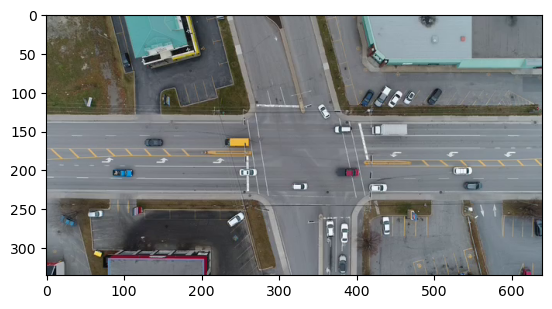

In [14]:
def plot_background_img():
    
    # 读取视频的第一帧
    video_path = 'one_video/DJI_0007.mp4'  # 将 'your_video.mp4' 替换为你的实际文件名
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    cap.release()

    
    if ret:
        # 将 BGR 图像转换为 RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # 在 Matplotlib 中显示图像
        plt.imshow(frame_rgb)
        
        # 绘制 scatter plot 叠加在图像上
        # plt.scatter(df['center_x'], df['center_y'], color='pink', s=0.5)
        
        
        plt.axis('on')  # 如果你不想显示坐标轴
        plt.savefig('background.jpeg')
        plt.show()
        
    else:
        print("cannot read video, pls cheack video dir")

plot_background_img()

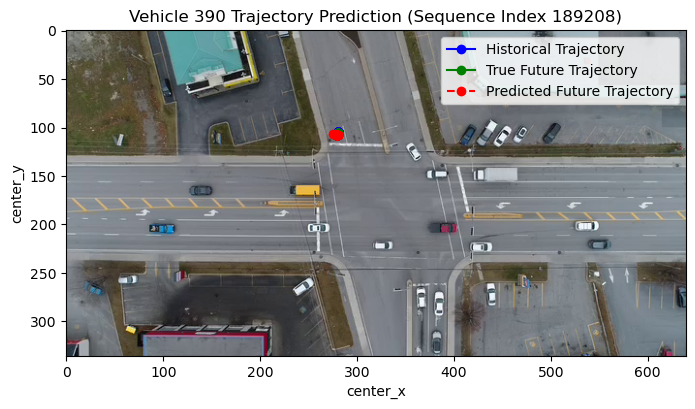

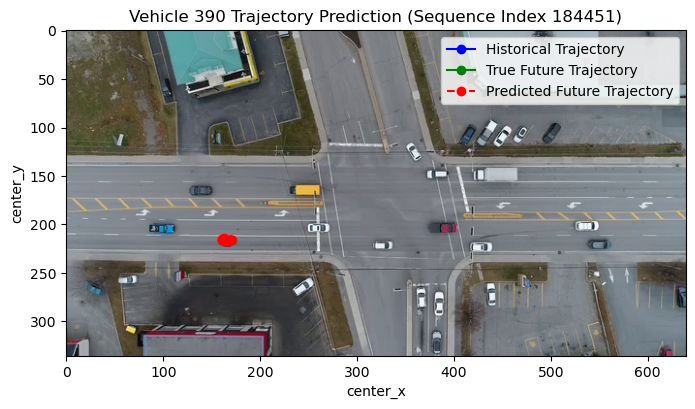

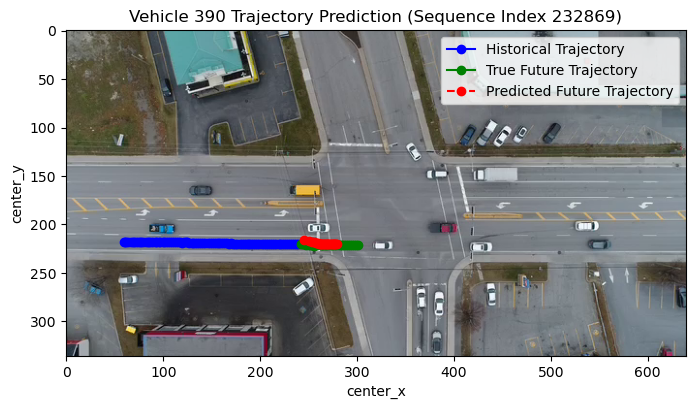

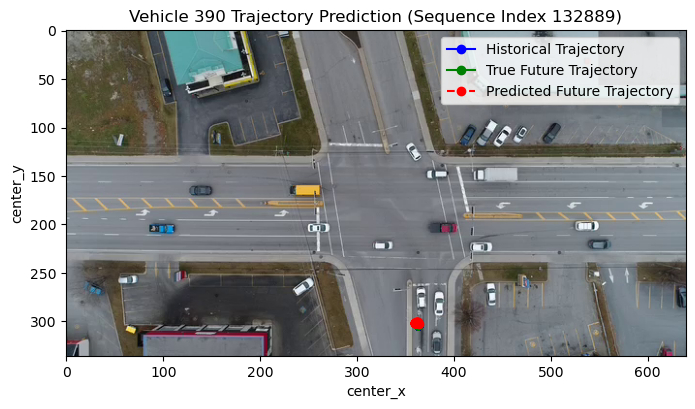

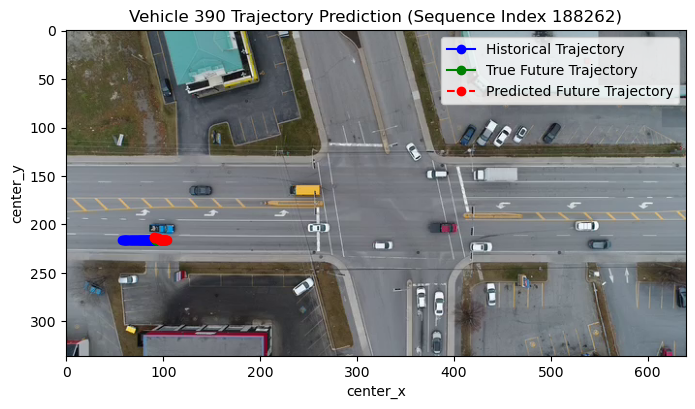

In [51]:
import torch
import matplotlib.pyplot as plt
import random

# Set random seed for reproducibility
# random.seed(42)

model.eval()
with torch.no_grad():
    # Collect all indices from all vehicle IDs
    all_indices = []
    index_to_vehicle_id = {}
    for vehicle_id, indices in vehicle_id_to_indices.items():
        for idx in indices:
            all_indices.append(idx)
            index_to_vehicle_id[idx] = vehicle_id  # Map index to vehicle ID

    # Randomly select 5 indices
    num_samples = 5
    if len(all_indices) >= num_samples:
        selected_indices = random.sample(all_indices, num_samples)
    else:
        selected_indices = all_indices  # If less than 5 sequences are available

    for idx in selected_indices:
        test_input = inputs[idx].unsqueeze(0).to(device)
        true_target = targets[idx].to(device)

        # Perform prediction
        predicted_output = model(test_input, target_len)

        # Convert predictions and true targets to NumPy arrays
        predicted_output = predicted_output.squeeze(0).cpu().numpy()
        true_target = true_target.cpu().numpy()

        # Get historical input data for visualization
        history_input = test_input.squeeze(0).cpu().numpy()

        # **Inverse scaling**
        numeric_feature_indices = [0, 1]  # Indices of 'center_x' and 'center_y'

        # Inverse transform historical inputs
        history_input_numeric = history_input[:, numeric_feature_indices]
        history_input_unscaled = scaler.inverse_transform(history_input_numeric)

        # Inverse transform predicted outputs
        predicted_output_unscaled = scaler.inverse_transform(predicted_output)

        # Inverse transform true targets
        true_target_unscaled = scaler.inverse_transform(true_target)

        # **Visualization**
        plt.figure(figsize=(8, 6))

        # Plot historical trajectory
        plt.plot(history_input_unscaled[:, 0], history_input_unscaled[:, 1], 'bo-', label='Historical Trajectory')

        # Plot true future trajectory
        plt.plot(true_target_unscaled[:, 0], true_target_unscaled[:, 1], 'go-', label='True Future Trajectory')

        # Plot predicted future trajectory
        plt.plot(predicted_output_unscaled[:, 0], predicted_output_unscaled[:, 1], 'ro--', label='Predicted Future Trajectory')

        plt.legend()
        plt.xlabel('center_x')
        plt.ylabel('center_y')
        plt.title(f'Vehicle {vehicle_id} Trajectory Prediction (Sequence Index {idx})')

        # Uncomment the following line if you have a background image plotting function
        plot_background_img()

        plt.show()

In [44]:
torch.save(model.state_dict(), eval_video_path/'trajectory_predictor.pth')

In [45]:
import joblib

# 训练完成后，保存 scaler
joblib.dump(scaler, eval_video_path/'scaler.save')

['eval_model_on_video/scaler.save']